In [2]:
from matplotlib import pyplot as plt 
import networkx as nx 

In [3]:
# Read the gml file
G = nx.read_gml('../data/graph/LEMD_EGLL_2023_04_01.gml')
print('Route graph read. {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))

Route graph read. 221 nodes and 1182 edges


c:\Users\hoang\anaconda3\envs\equinox\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\hoang\anaconda3\envs\equinox\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\hoang\anaconda3\envs\equinox\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\hoang\anaconda3\envs\equinox\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


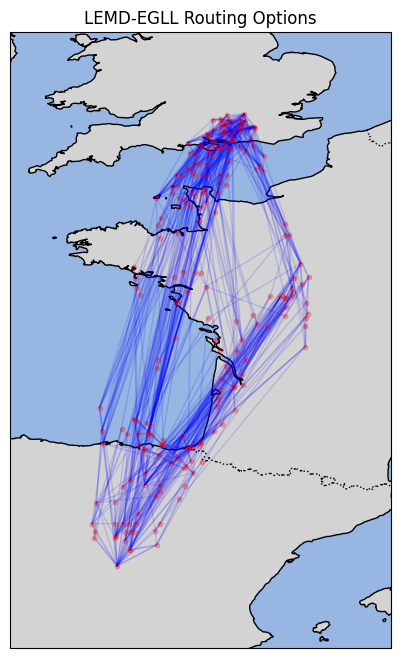

In [4]:
def plot_route_graph(G):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    # Extract node positions
    node_lats = []
    node_lons = []
    for n, data in G.nodes(data=True):
        node_lats.append(float(data['lat']))
        node_lons.append(float(data['lon']))

    # Set up the map
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN)

    # Plot edges
    for u, v in G.edges():
        lat1 = float(G.nodes[u]['lat'])
        lon1 = float(G.nodes[u]['lon'])
        lat2 = float(G.nodes[v]['lat'])
        lon2 = float(G.nodes[v]['lon'])
        ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=1, alpha=0.15, transform=ccrs.PlateCarree())

    # Plot nodes
    ax.scatter(node_lons, node_lats, color='red', s=10, zorder=5, transform=ccrs.PlateCarree(), alpha=0.25)

    # Optionally, set extent to fit the route
    margin = 2
    min_lon, max_lon = min(node_lons), max(node_lons)
    min_lat, max_lat = min(node_lats), max(node_lats)
    ax.set_extent([min_lon - margin, max_lon + margin, min_lat - margin, max_lat + margin], crs=ccrs.PlateCarree())

    plt.title("LEMD-EGLL Routing Options")
    plt.show()

plot_route_graph(G)

## Show charges

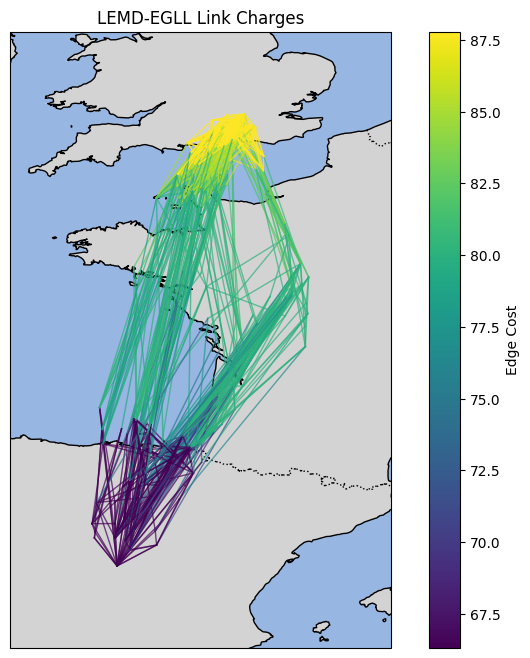

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Step 1: Load the charge matrix ---
charges = np.load('../data/graph/LEMD_EGLL_2023_04_01_charges.npy')

# --- Step 2: Map node names to node ids ---
from equinox.feateng.laplace import enumerate_nodes
node_mapping = enumerate_nodes(G)
id_to_name = {idx: name for name, idx in node_mapping.items()}

# --- Step 3: Assign charge to each edge ---
# Assume charges is a 2D matrix where charges[i, j] is the cost from node i to node j
for u, v in G.edges():
    uid = node_mapping[u]
    vid = node_mapping[v]
    G[u][v]['charge'] = charges[uid, vid]

# --- Step 4: Plot with edge colors by cost ---
def plot_route_graph_colored(G):
    # Extract node positions
    node_lats = [float(data['lat']) for n, data in G.nodes(data=True)]
    node_lons = [float(data['lon']) for n, data in G.nodes(data=True)]

    # Set up the map
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN)

    # Get all charges for normalization
    edge_charges = [G[u][v]['charge'] for u, v in G.edges()]
    vmin, vmax = np.min(edge_charges), np.max(edge_charges)
    cmap = plt.get_cmap('viridis')

    # Plot edges with color by charge
    for u, v in G.edges():
        lat1, lon1 = float(G.nodes[u]['lat']), float(G.nodes[u]['lon'])
        lat2, lon2 = float(G.nodes[v]['lat']), float(G.nodes[v]['lon'])
        charge = G[u][v]['charge']
        color = cmap((charge - vmin) / (vmax - vmin) if vmax > vmin else 0.5)
        ax.plot([lon1, lon2], [lat1, lat2], color=color, linewidth=1, alpha=0.7, transform=ccrs.PlateCarree())

    # Plot nodes
    # ax.scatter(node_lons, node_lats, color='red', s=10, zorder=5, transform=ccrs.PlateCarree(), alpha=0.25)

    # Optionally, set extent to fit the route
    margin = 2
    min_lon, max_lon = min(node_lons), max(node_lons)
    min_lat, max_lat = min(node_lats), max(node_lats)
    ax.set_extent([min_lon - margin, max_lon + margin, min_lat - margin, max_lat + margin], crs=ccrs.PlateCarree())

    plt.title("LEMD-EGLL Link Charges")
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=ax, label='Edge Cost')
    plt.show()

plot_route_graph_colored(G)